In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [38]:
import pandas as pd

# Load the dataset
file_path = "Data/RT_IOT2022.csv"  # Ensure the file is in the working directory
df = pd.read_csv(file_path)

# Display dataset information
print("Dataset Information:")
print(df.info())

# Display first few rows
print("\nFirst 5 Rows:")
df.head()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123117 entries, 0 to 123116
Data columns (total 85 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   no                        123117 non-null  int64  
 1   id.orig_p                 123117 non-null  int64  
 2   id.resp_p                 123117 non-null  int64  
 3   proto                     123117 non-null  object 
 4   service                   123117 non-null  object 
 5   flow_duration             123117 non-null  float64
 6   fwd_pkts_tot              123117 non-null  int64  
 7   bwd_pkts_tot              123117 non-null  int64  
 8   fwd_data_pkts_tot         123117 non-null  int64  
 9   bwd_data_pkts_tot         123117 non-null  int64  
 10  fwd_pkts_per_sec          123117 non-null  float64
 11  bwd_pkts_per_sec          123117 non-null  float64
 12  flow_pkts_per_sec         123117 non-null  float64
 13  down_up_ratio          

,no,id.orig_p,id.resp_p,proto,service,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,Attack_type
0,0,38667,1883,tcp,mqtt,32.011598,9,5,3,3,...,0.0,2.972918e+07,2.972918e+07,2.972918e+07,2.972918e+07,0.0,64240,26847,502,MQTT_Publish
1,1,51143,1883,tcp,mqtt,31.883584,9,5,3,3,...,0.0,2.985528e+07,2.985528e+07,2.985528e+07,2.985528e+07,0.0,64240,26847,502,MQTT_Publish
2,2,44761,1883,tcp,mqtt,32.124053,9,5,3,3,...,0.0,2.984215e+07,2.984215e+07,2.984215e+07,2.984215e+07,0.0,64240,26847,502,MQTT_Publish
3,3,60893,1883,tcp,mqtt,31.961063,9,5,3,3,...,0.0,2.991377e+07,2.991377e+07,2.991377e+07,2.991377e+07,0.0,64240,26847,502,MQTT_Publish
4,4,51087,1883,tcp,mqtt,31.902362,9,5,3,3,...,0.0,2.981470e+07,2.981470e+07,2.981470e+07,2.981470e+07,0.0,64240,26847,502,MQTT_Publish


In [39]:
# Check for missing values
print("Missing Values Per Column:")
print(df.isnull().sum())


Missing Values Per Column:
no                      0
id.orig_p               0
id.resp_p               0
proto                   0
service                 0
                       ..
idle.std                0
fwd_init_window_size    0
bwd_init_window_size    0
fwd_last_window_size    0
Attack_type             0
Length: 85, dtype: int64


C:\Users\binwa\AppData\Local\Temp\ipykernel_32916\2738644887.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df['Attack_type'], order=df['Attack_type'].value_counts().index, palette="viridis")


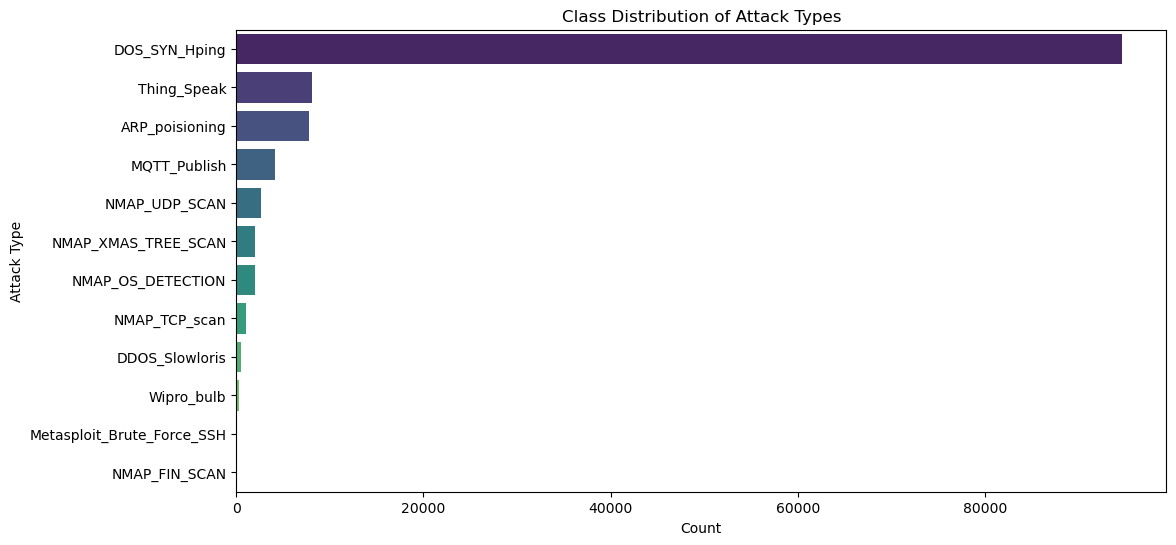

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.countplot(y=df['Attack_type'], order=df['Attack_type'].value_counts().index, palette="viridis")
plt.title("Class Distribution of Attack Types")
plt.xlabel("Count")
plt.ylabel("Attack Type")
plt.savefig("class_distribution.png")
plt.show()


In [41]:
# Select 4 attack types for multi-class classification
selected_classes = ['DOS_SYN_Hping', 'Thing_Speak', 'MQTT_Publish', 'NMAP_UDP_SCAN']
df_filtered = df[df['Attack_type'].isin(selected_classes)]

# Display updated class distribution
print("Filtered dataset with selected classes:")
df_filtered['Attack_type'].value_counts()


Filtered dataset with selected classes:


Attack_type
DOS_SYN_Hping    94659
Thing_Speak       8108
MQTT_Publish      4146
NMAP_UDP_SCAN     2590
Name: count, dtype: int64

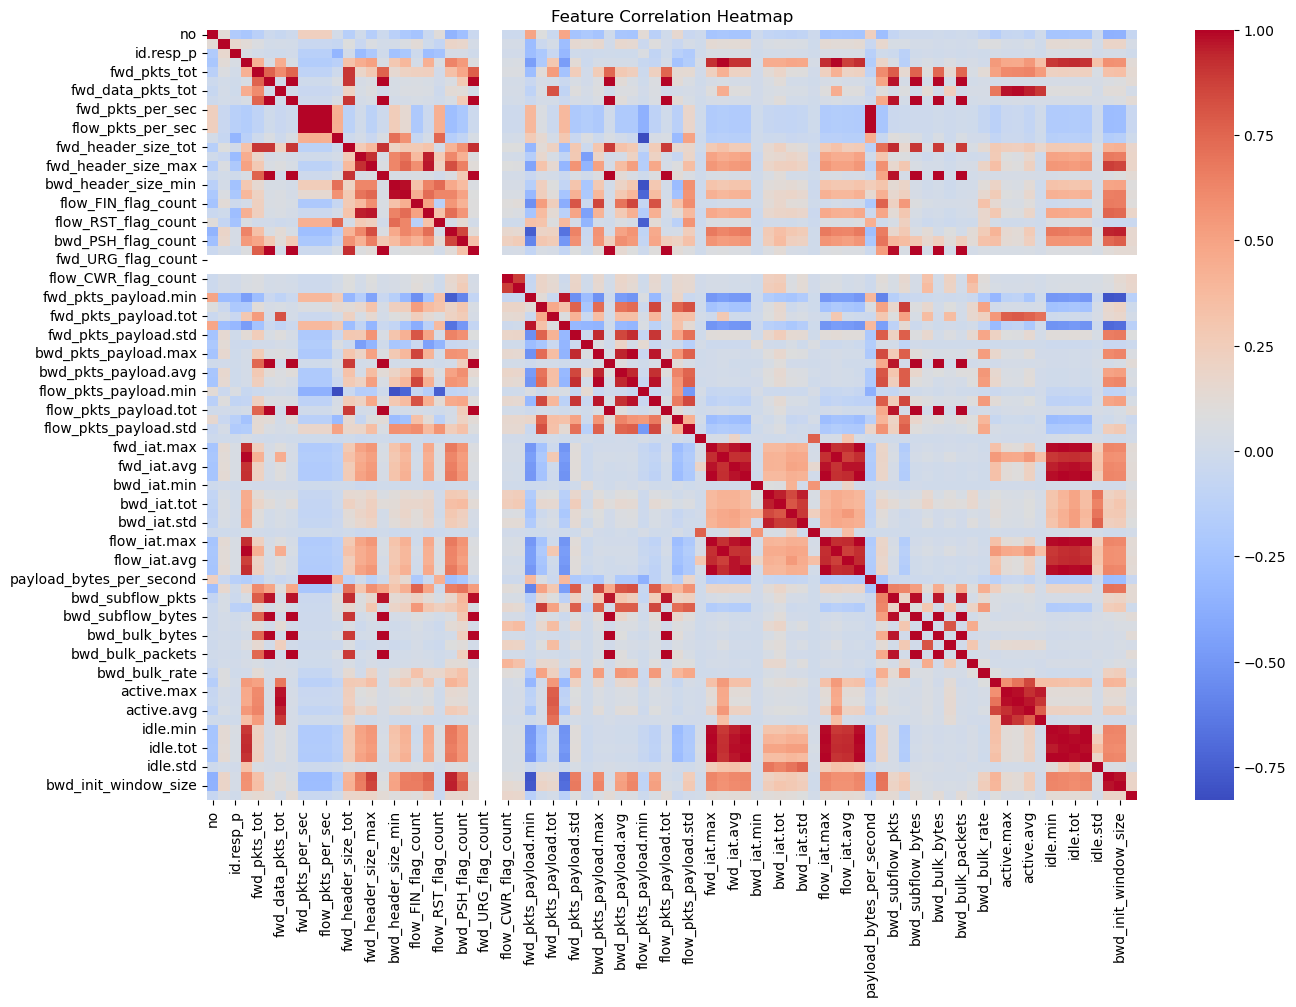

In [42]:
import numpy as np

plt.figure(figsize=(15, 10))
sns.heatmap(df_filtered.corr(numeric_only=True), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.savefig("correlation_heatmap.png")
plt.show()


In [43]:
# Find the minimum sample count among the selected 4 classes
min_sample_size = df_filtered['Attack_type'].value_counts().min()
print(f"Smallest class size among the selected 4 classes: {min_sample_size}")


Smallest class size among the selected 4 classes: 2590


In [44]:
from sklearn.utils import resample

# Create an empty DataFrame to store the balanced dataset
df_balanced = pd.DataFrame()

# Downsample each class to match the smallest class size
for attack_type in df_filtered['Attack_type'].unique():
    subset = df_filtered[df_filtered['Attack_type'] == attack_type]
    subset_balanced = resample(subset, replace=False, n_samples=min_sample_size, random_state=42)
    df_balanced = pd.concat([df_balanced, subset_balanced])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify new class distribution
print("Balanced class distribution:\n", df_balanced['Attack_type'].value_counts())


Balanced class distribution:
 Attack_type
Thing_Speak      2590
NMAP_UDP_SCAN    2590
MQTT_Publish     2590
DOS_SYN_Hping    2590
Name: count, dtype: int64


In [45]:
from sklearn.preprocessing import LabelEncoder

# Encode the target variable
le = LabelEncoder()
df_balanced['Attack_type'] = le.fit_transform(df_balanced['Attack_type'])

# Display the unique classes and their numeric representation
print("Encoded Class Labels:")
print(dict(zip(le.classes_, le.transform(le.classes_))))


Encoded Class Labels:
{'DOS_SYN_Hping': 0, 'MQTT_Publish': 1, 'NMAP_UDP_SCAN': 2, 'Thing_Speak': 3}


In [46]:
# Define selected features based on importance
selected_features = ['flow_duration', 'fwd_pkts_tot', 'bwd_pkts_tot', 'fwd_pkts_per_sec', 
                     'bwd_pkts_per_sec', 'flow_pkts_per_sec', 'down_up_ratio', 'fwd_header_size_tot',
                     'bwd_header_size_tot', 'flow_FIN_flag_count', 'flow_SYN_flag_count']

# Ensure selected features exist in the dataset
selected_features = [col for col in selected_features if col in df_balanced.columns]

# Define feature matrix (X) and target variable (y)
X = df_balanced[selected_features]
y = df_balanced['Attack_type']


In [47]:
from sklearn.model_selection import train_test_split

# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")


Training set size: 8288 samples
Test set size: 2072 samples


In [48]:
from sklearn.preprocessing import StandardScaler

# Normalize the numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [49]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the ANN model
ann_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),  # Prevent overfitting
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(len(le.classes_), activation='softmax')  # Multi-class classification
])

# Compile the model
ann_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
ann_model.summary()


c:\Users\binwa\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,052 (39.27 KB)

 Trainable params: 10,052 (39.27 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
# Train the model
history = ann_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32)


Epoch 1/30
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8849 - loss: 0.5106 - val_accuracy: 0.9836 - val_loss: 0.1014
Epoch 2/30
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9862 - loss: 0.1452 - val_accuracy: 0.9875 - val_loss: 0.0771
Epoch 3/30
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9867 - loss: 0.0841 - val_accuracy: 0.9875 - val_loss: 0.0701
Epoch 4/30
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9879 - loss: 0.0803 - val_accuracy: 0.9870 - val_loss: 0.0657
Epoch 5/30
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9891 - loss: 0.0536 - val_accuracy: 0.9875 - val_loss: 0.0642
Epoch 6/30
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9893 - loss: 0.0511 - val_accuracy: 0.9875 - val_loss: 0.0658
Epoch 7/30
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9907 - loss: 0.0468 - val_accuracy: 0.9879 - val_loss: 0.0637
Epoch 8/30
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9891 - loss: 0.0510 - val_accuracy: 0.

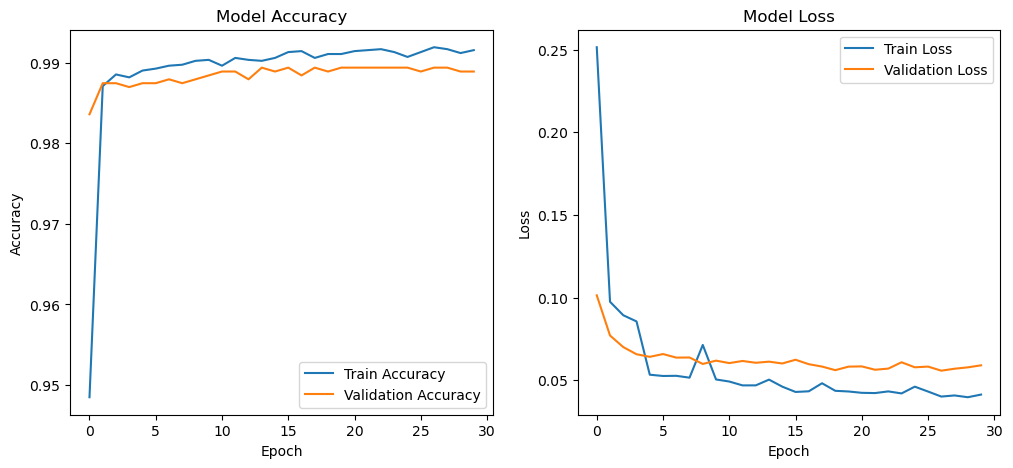

In [51]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [52]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# Predict using ANN Model
ann_preds = np.argmax(ann_model.predict(X_test), axis=1)

# Print accuracy
print("ANN Model Accuracy:", accuracy_score(y_test, ann_preds))

# Print classification report
print("\nClassification Report - ANN:")
print(classification_report(y_test, ann_preds))


65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
ANN Model Accuracy: 0.9888996138996139

Classification Report - ANN:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       518
           1       1.00      1.00      1.00       518
           2       0.98      0.98      0.98       518
           3       0.98      0.97      0.98       518

    accuracy                           0.99      2072
   macro avg       0.99      0.99      0.99      2072
weighted avg       0.99      0.99      0.99      2072



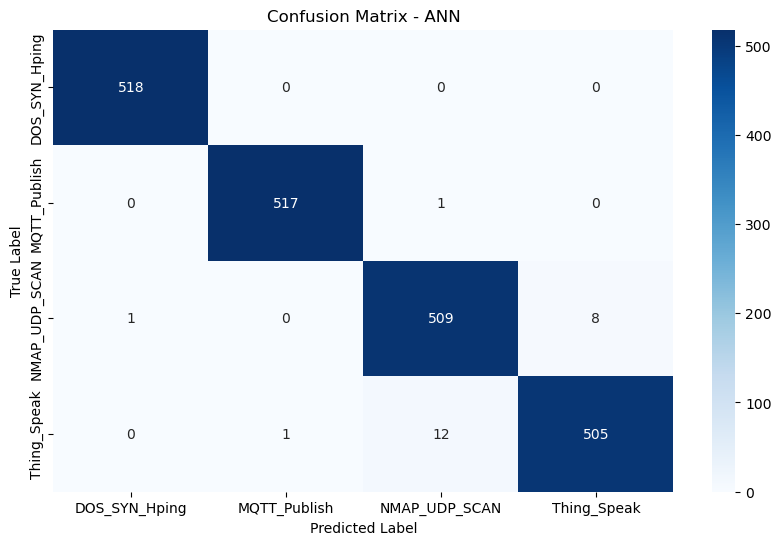

In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_test, ann_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - ANN")
plt.show()


65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


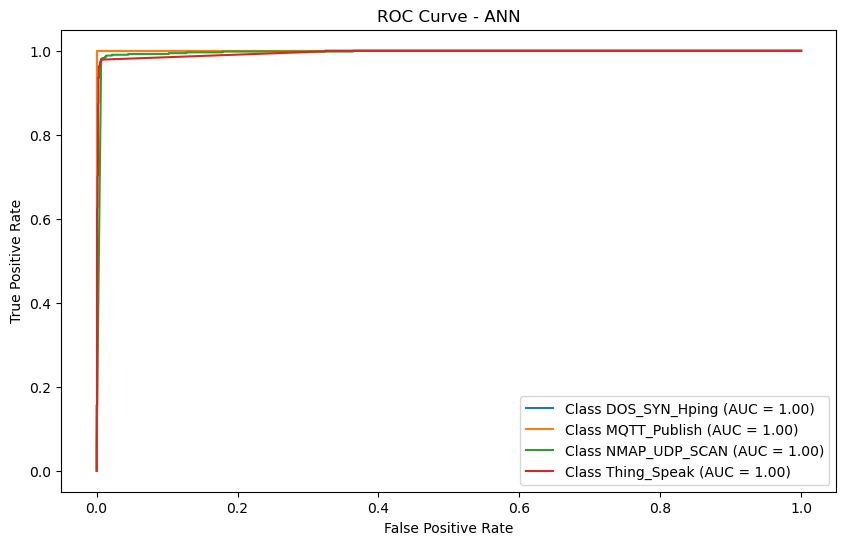

In [54]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Number of classes
n_classes = len(le.classes_)

# Get probability predictions from ANN
ann_probs = ann_model.predict(X_test)

# Plot ROC curve for ANN
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test == i, ann_probs[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {le.classes_[i]} (AUC = {auc_score:.2f})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - ANN")
plt.legend()
plt.show()



In [55]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)


In [56]:
from sklearn.metrics import classification_report, accuracy_score

# Print accuracy
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

# Print classification report
print("\nClassification Report - Random Forest:")
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.9898648648648649

Classification Report - Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       518
           1       1.00      0.99      1.00       518
           2       0.98      0.99      0.98       518
           3       0.98      0.98      0.98       518

    accuracy                           0.99      2072
   macro avg       0.99      0.99      0.99      2072
weighted avg       0.99      0.99      0.99      2072



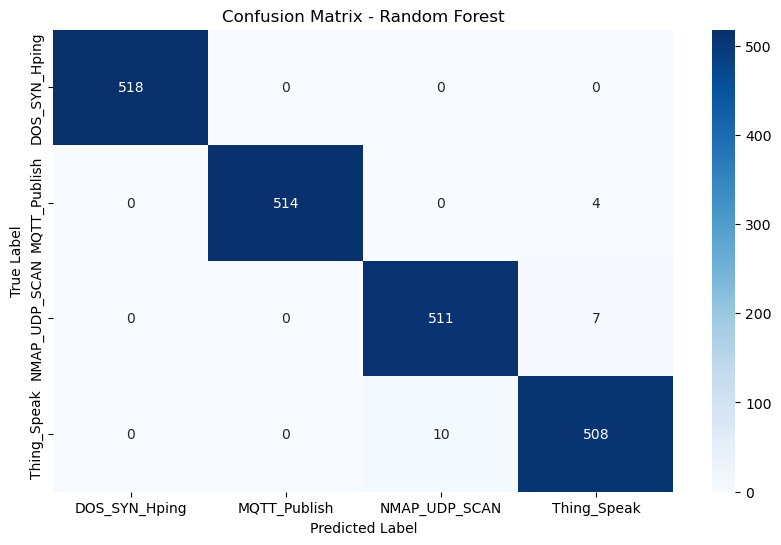

In [57]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

# Plot confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest")
plt.show()


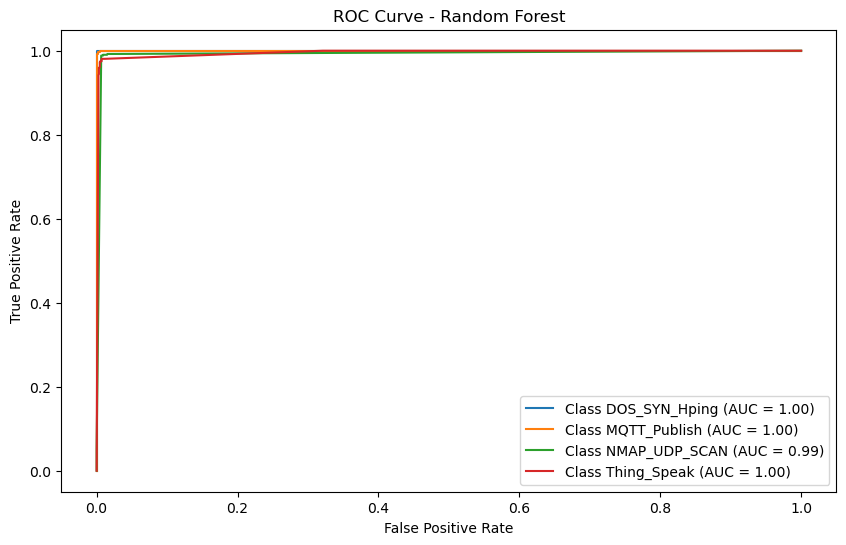

In [58]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Get probability predictions from Random Forest
rf_probs = rf_model.predict_proba(X_test)

# Number of classes
n_classes = len(le.classes_)

# Plot ROC curve for Random Forest
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test == i, rf_probs[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {le.classes_[i]} (AUC = {auc_score:.2f})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()


In [59]:
from sklearn.svm import SVC

# Initialize and train SVM
svm_model = SVC(kernel='rbf', C=1, gamma='scale', probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Predict on the test set
y_pred_svm = svm_model.predict(X_test)


In [60]:
from sklearn.metrics import classification_report, accuracy_score

# Print accuracy
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))

# Print classification report
print("\nClassification Report - SVM:")
print(classification_report(y_test, y_pred_svm))


SVM Accuracy: 0.9884169884169884

Classification Report - SVM:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       518
           1       1.00      1.00      1.00       518
           2       0.98      0.98      0.98       518
           3       0.98      0.97      0.98       518

    accuracy                           0.99      2072
   macro avg       0.99      0.99      0.99      2072
weighted avg       0.99      0.99      0.99      2072



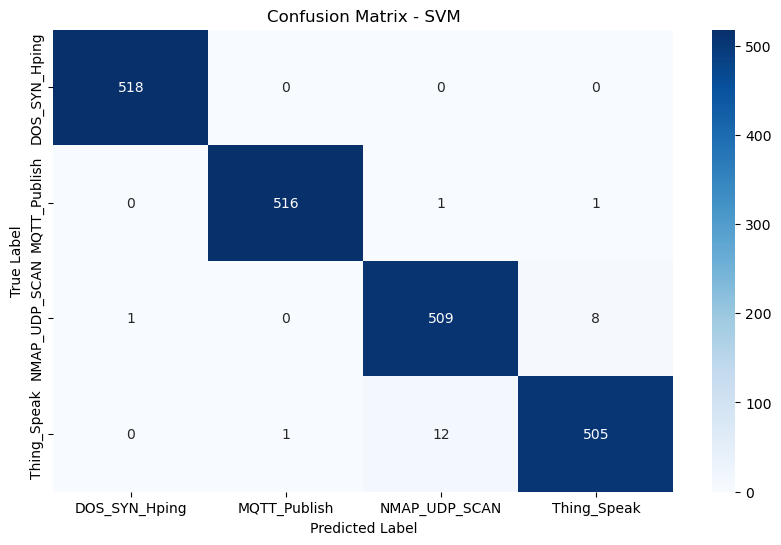

In [61]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)

# Plot confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - SVM")
plt.show()


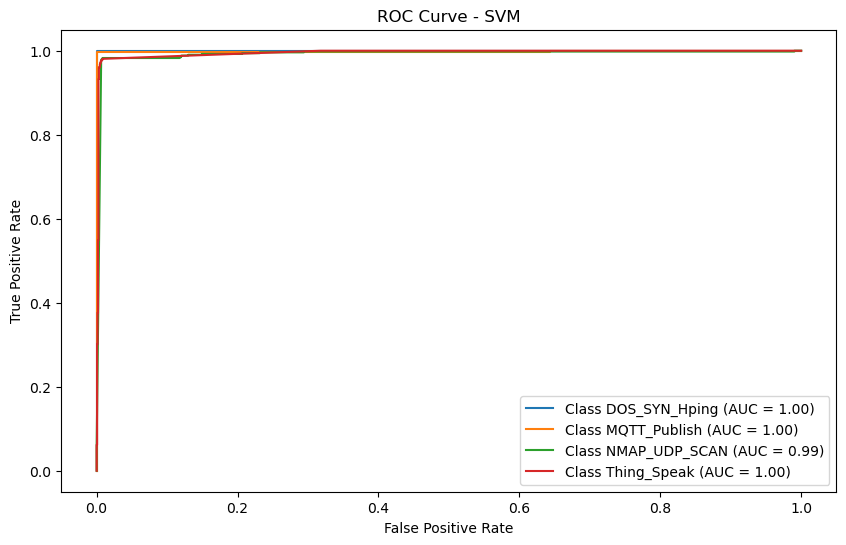

In [62]:
# Get probability predictions from SVM
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

svm_probs = svm_model.predict_proba(X_test)
n_classes = len(le.classes_)
# Plot ROC curve for SVM
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test == i, svm_probs[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {le.classes_[i]} (AUC = {auc_score:.2f})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SVM")
plt.legend()
plt.show()


In [63]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation for each model
rf_cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')
svm_cv_scores = cross_val_score(svm_model, X_train, y_train, cv=5, scoring='accuracy')

print("Random Forest Cross-Validation Accuracy:", rf_cv_scores.mean())
print("SVM Cross-Validation Accuracy:", svm_cv_scores.mean())


Random Forest Cross-Validation Accuracy: 0.9922777440882087
SVM Cross-Validation Accuracy: 0.9898646164642745


In [64]:
from sklearn.metrics import accuracy_score, classification_report

# Random Forest Evaluation
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# SVM Evaluation
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm))



Random Forest Accuracy: 0.9898648648648649

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       518
           1       1.00      0.99      1.00       518
           2       0.98      0.99      0.98       518
           3       0.98      0.98      0.98       518

    accuracy                           0.99      2072
   macro avg       0.99      0.99      0.99      2072
weighted avg       0.99      0.99      0.99      2072

SVM Accuracy: 0.9884169884169884

SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       518
           1       1.00      1.00      1.00       518
           2       0.98      0.98      0.98       518
           3       0.98      0.97      0.98       518

    accuracy                           0.99      2072
   macro avg       0.99      0.99      0.99      2072
weighted avg       0.99      0.99      0.99

In [65]:
# ANN Evaluation
import numpy as np
ann_preds = np.argmax(ann_model.predict(X_test), axis=1)
print("ANN Accuracy:", accuracy_score(y_test, ann_preds))
print("\nANN Classification Report:")
print(classification_report(y_test, ann_preds))

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
ANN Accuracy: 0.9888996138996139

ANN Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       518
           1       1.00      1.00      1.00       518
           2       0.98      0.98      0.98       518
           3       0.98      0.97      0.98       518

    accuracy                           0.99      2072
   macro avg       0.99      0.99      0.99      2072
weighted avg       0.99      0.99      0.99      2072



Random Forest 5-Fold CV Accuracy: 0.9914 ± 0.0022
SVM 5-Fold CV Accuracy: 0.4742 ± 0.0017
ANN 5-Fold CV Accuracy: 0.9496 ± 0.0518


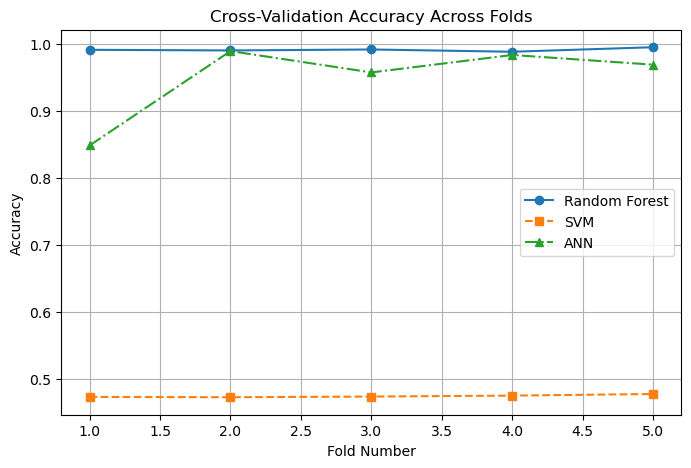

In [66]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import numpy as np
import matplotlib.pyplot as plt

# Define number of folds
k_folds = 5
cv = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Define models
rf_model = RandomForestClassifier(n_estimators=100, criterion="entropy", random_state=42)
svm_model = SVC(kernel="rbf", C=1, gamma="scale", probability=True, random_state=42)
ann_model = MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', solver='adam', max_iter=300, random_state=42)

# Perform cross-validation
rf_cv_scores = cross_val_score(rf_model, X, y, cv=cv, scoring="accuracy")
svm_cv_scores = cross_val_score(svm_model, X, y, cv=cv, scoring="accuracy")
ann_cv_scores = cross_val_score(ann_model, X, y, cv=cv, scoring="accuracy")

# Print results
print(f"Random Forest 5-Fold CV Accuracy: {rf_cv_scores.mean():.4f} ± {rf_cv_scores.std():.4f}")
print(f"SVM 5-Fold CV Accuracy: {svm_cv_scores.mean():.4f} ± {svm_cv_scores.std():.4f}")
print(f"ANN 5-Fold CV Accuracy: {ann_cv_scores.mean():.4f} ± {ann_cv_scores.std():.4f}")

# Save scores for visualization
folds = np.arange(1, k_folds + 1)

# Plot cross-validation results
plt.figure(figsize=(8, 5))
plt.plot(folds, rf_cv_scores, marker='o', linestyle='-', label='Random Forest')
plt.plot(folds, svm_cv_scores, marker='s', linestyle='--', label='SVM')
plt.plot(folds, ann_cv_scores, marker='^', linestyle='-.', label='ANN')

# Labels and title
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Accuracy Across Folds')
plt.legend()
plt.grid(True)

# Save the figure
plt.savefig("cross_validation_accuracy.png", dpi=300)
plt.show()
